# Titanic data: Learning from disaster
### task: 
predicting survival of a passage given his/her ticket class, class, name, gender, age, number of siblings / spouses aboard, number of parents / children aboard, ticket number, cabin number and Port of embarkation

In [319]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

## Load data and set target as survival

In [320]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#y = train.Survived

## Clean and explore data set:

In [321]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [322]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


before any modeling can be done on both the training and testing data sets, there must be no null values for any of the columns

In [323]:
df = train.append(test, ignore_index=True)

In [324]:
#since a vast majority embarked from S, the null values will be filled with S
df.Embarked = np.where(df.Embarked.isnull(), 'S', df.Embarked)

#U will be used to fill in the cabin value for Unknown
df['Cabin'] = np.where(df.Cabin.isnull(), 'U', df.Cabin)

#median fare will be used to fill in the null value for Fare
df.Fare = np.where(df.Fare.isnull(), df.Fare.median(), df.Fare)

## Visual representation of survival based on sex

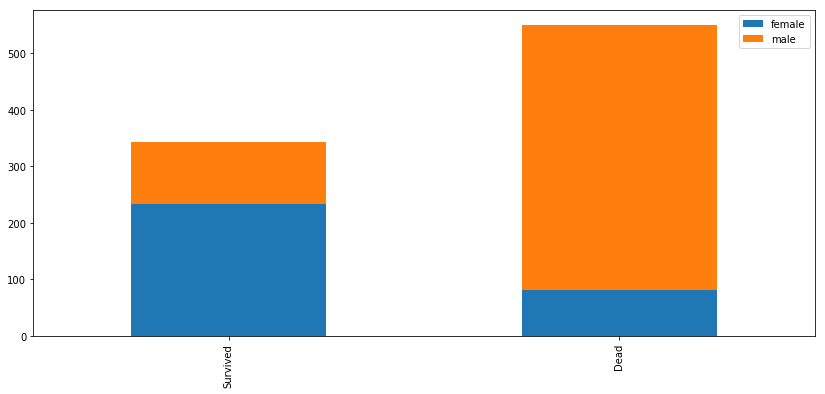

In [325]:
survived_by_sex = df[df['Survived'] == 1]['Sex'].value_counts()
not_survived_by_sex = df[df['Survived'] == 0]['Sex'].value_counts()
plot_df = pd.DataFrame([survived_by_sex, not_survived_by_sex])
plot_df.index = ['Survived', 'Dead']
plot_df.plot(kind='bar', stacked=True, figsize=(14,6))

## Visual representation of survival based on fare paid

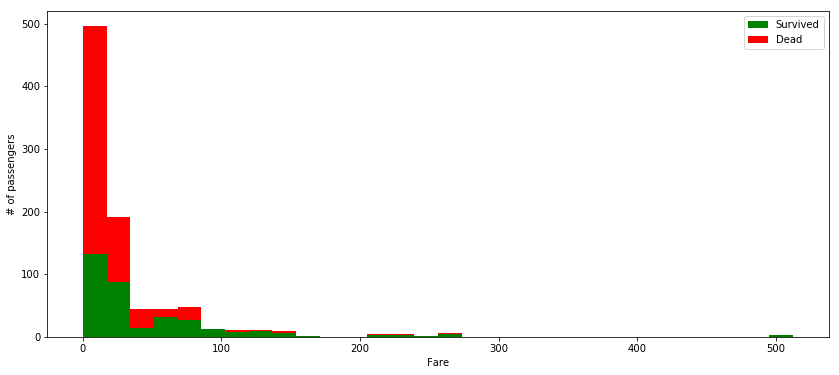

In [326]:
fig = plt.figure(figsize=(14,6))
plt.hist([df[df['Survived'] == 1]['Fare'], df[df['Survived'] == 0]['Fare']], stacked=True, color= ['g', 'r'], bins = 30, label = ['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('# of passengers')
plt.legend()

## Average fare paid based on the class

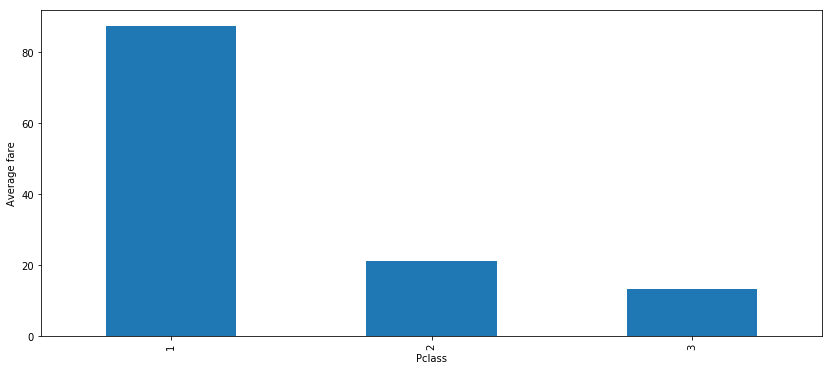

In [327]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
df.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(14,6), ax = ax)

## Visual representation based on where passenger embarked

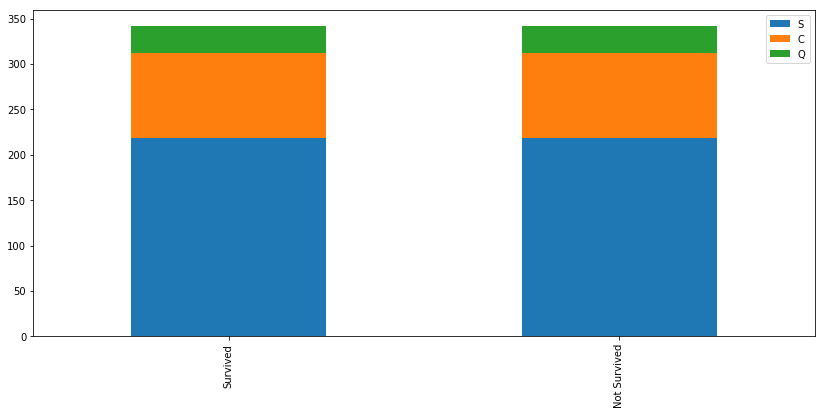

In [328]:
survived_by_embark = df[df['Survived'] == 1]['Embarked'].value_counts()
not_survived_by_embark = df[df['Survived'] == 1]['Embarked'].value_counts()
plot_df = pd.DataFrame([survived_by_embark, not_survived_by_embark])
plot_df.index = ['Survived', 'Not Survived']
plot_df.plot(kind='bar', stacked=True, figsize=(14,6))

In [329]:
y = train.Survived

new_df = df.copy()
new_df.drop('Survived', axis=1, inplace=True)

## Feature engineering:
features will be created and enhanced in order to optimize the accuracy of the prediction

In [330]:
#extract title from name and map titles to categories of titles
title_dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
new_df['Title'] = new_df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
new_df['Title'] = new_df.Title.map(title_dictionary)

In [331]:
#the reason to not use median age to fill in is because there is a diverse range of ages based on title, sex, and pclass
grouped_train = new_df.head(891).groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()

grouped_test = new_df.iloc[891:].groupby(['Sex','Pclass','Title'])
grouped_median_test = grouped_test.median()

In [332]:
grouped_median_train

Age       Fare  Parch  PassengerId  SibSp
Sex    Pclass Title                                              
female 1      Miss     30.0   88.25000    0.0        369.0    0.0
              Mrs      40.0   79.20000    0.0        499.0    1.0
              Officer  49.0   25.92920    0.0        797.0    0.0
              Royalty  40.5   63.05000    0.0        658.5    0.5
       2      Miss     24.0   13.00000    0.0        437.5    0.0
              Mrs      31.5   26.00000    0.0        439.5    1.0
       3      Miss     18.0    8.75625    0.0        372.0    0.0
              Mrs      31.0   15.97500    1.0        405.5    1.0
male   1      Master    4.0  120.00000    2.0        446.0    1.0
              Mr       40.0   42.40000    0.0        463.0    0.0
              Officer  51.0   35.50000    0.0        648.0    0.0
              Royalty  40.0   27.72080    0.0        600.0    0.0
       2      Master    1.0   26.00000    1.0        408.0    1.0
              Mr       31.0   13.00000    0.0        440.0    0.0
              Officer  46.5   13.00000    0.0        358.5    0.0
       3      Master    4.0   28.51250    1.0        270.5    3.5
              Mr       26.0    7.89580    0.0        472.0    0.0

In [333]:
grouped_median_test

Age       Fare  Parch  PassengerId  SibSp
Sex    Pclass Title                                              
female 1      Miss     32.0  158.20835    0.0       1074.0    0.0
              Mrs      48.0   63.35830    0.0       1076.0    1.0
              Royalty  39.0  108.90000    0.0       1306.0    0.0
       2      Miss     19.5   24.50000    1.0       1121.0    1.0
              Mrs      29.0   26.00000    0.0       1123.5    0.0
       3      Miss     22.0    7.87920    0.0       1090.5    0.0
              Mrs      28.0   14.28125    0.5       1048.0    1.0
male   1      Master    9.5  198.43750    2.0       1022.0    1.0
              Mr       42.0   50.24790    0.0       1102.0    0.0
              Officer  53.0   81.85830    0.0       1094.0    1.0
       2      Master    5.0   27.75000    1.5       1033.5    0.5
              Mr       28.0   13.00000    0.0       1156.0    0.0
              Officer  35.5   19.50000    0.5       1048.5    0.5
       3      Master    7.0   15.24580    1.0       1173.0    1.0
              Mr       25.0    7.85420    0.0       1101.0    0.0

In [334]:
#to more accurately estimate the age of the passengers with missing age data, 
#age will be filled with the median age based on sex, Pclass, and title

def fillAge(row, grouped_median):
    if (row['Sex'] == 'female') & (row['Pclass'] == 1):
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 1, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 1, 'Mrs']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['female', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['female', 1, 'Royalty']['Age']
    
    elif (row['Sex'] == 'female') & (row['Pclass'] == 2):
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 2, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 2, 'Mrs']['Age']
    
    elif (row['Sex'] == 'female') & (row['Pclass'] == 3):
        if row['Title'] == 'Miss':
            return grouped_median.loc['female', 3, 'Miss']['Age']
        elif row['Title'] == 'Mrs':
            return grouped_median.loc['female', 3, 'Mrs']['Age']
    
    elif row['Sex']=='male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 1, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 1, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 1, 'Officer']['Age']
        elif row['Title'] == 'Royalty':
            return grouped_median.loc['male', 1, 'Royalty']['Age']
        
    elif row['Sex']=='male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 2, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 2, 'Mr']['Age']
        elif row['Title'] == 'Officer':
            return grouped_median.loc['male', 2, 'Officer']['Age']
        
    elif row['Sex']=='male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return grouped_median.loc['male', 3, 'Master']['Age']
        elif row['Title'] == 'Mr':
            return grouped_median.loc['male', 3, 'Mr']['Age']

new_df.head(891).Age = new_df.head(891).apply(lambda x : fillAge(x, grouped_median_train) if np.isnan(x['Age']) 
                                                      else x['Age'], axis=1)        
new_df.iloc[891:].Age = new_df.iloc[891:].apply(lambda x : fillAge(x, grouped_median_test) if np.isnan(x['Age']) 
                                                      else x['Age'], axis=1)        


In [335]:
#after the ages have been filled in, name can be dropped and title is concatentated as dummy variables
new_df.drop('Name',axis=1,inplace=True)

titles_dummies = pd.get_dummies(new_df['Title'],prefix='Title')
new_df = pd.concat([new_df,titles_dummies],axis=1)

new_df.drop('Title',axis=1,inplace=True)

In [336]:
#embarked is added as dummy variables as well
embarked_dummies = pd.get_dummies(new_df['Embarked'],prefix='Embarked')
new_df = pd.concat([new_df,embarked_dummies],axis=1)
new_df.drop('Embarked',axis=1,inplace=True)

In [337]:
#the cabin along with sex and pclass are also added as a dummy variable
new_df['Cabin'] = new_df['Cabin'].map(lambda c : c[0])

cabin_dummies = pd.get_dummies(new_df['Cabin'], prefix='Cabin')
new_df = pd.concat([new_df,cabin_dummies], axis=1)
    
new_df.drop('Cabin', axis=1, inplace=True)

In [338]:
new_df['Sex'] = new_df['Sex'].map({'male':0,'female':1})

In [339]:
pclass_dummies = pd.get_dummies(new_df['Pclass'], prefix="Pclass")
new_df = pd.concat([new_df,pclass_dummies],axis=1)
new_df.drop('Pclass',axis=1,inplace=True)

In [340]:
#the ticket prefix is extracted so that it can also be added as dummy variables
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = filter(lambda t : not t.isdigit(), ticket)
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

new_df['Ticket'] = new_df['Ticket'].map(cleanTicket)    
tickets_dummies = pd.get_dummies(new_df['Ticket'], prefix='Ticket')
new_df = pd.concat([new_df, tickets_dummies], axis=1)
new_df.drop('Ticket', inplace=True, axis=1)

In [341]:
#families are more likely to survive so family size is added as a feature in addition whether the family is large or small
new_df['FamilySize'] = new_df['Parch'] + new_df['SibSp'] + 1
new_df['Singleton'] = new_df['FamilySize'].map(lambda x: 1 if x == 1 else 0)
new_df['SmallFamily'] = new_df['FamilySize'].map(lambda x: 1 if 2<=x<=4 else 0)
new_df['LargeFamily'] = new_df['FamilySize'].map(lambda x: 1 if 5<=x else 0)

In [342]:
new_df.drop('PassengerId', inplace=True, axis=1)

## Modeling:
now that special features have been extracted, the data set can now be used to make predictions

In [343]:
#split data set into training and testing sets
df_train = new_df[:len(train)]
df_test = new_df[len(train):]

In [344]:
#define the features
features = list(new_df.columns)
x = df_train[features]

In [345]:
#split the training set into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=0)

In [346]:
#the model that will be used will be the Random Forest classifier
clf = RandomForestClassifier(n_estimators=50)
rf = clf.fit(x_train,y_train)

#in order to further optimize which features have a significant impact the accuracy of the model
#a tree-based estimator is used to find out which features are irrelevant
features = pd.DataFrame()
features['feature'] = df_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

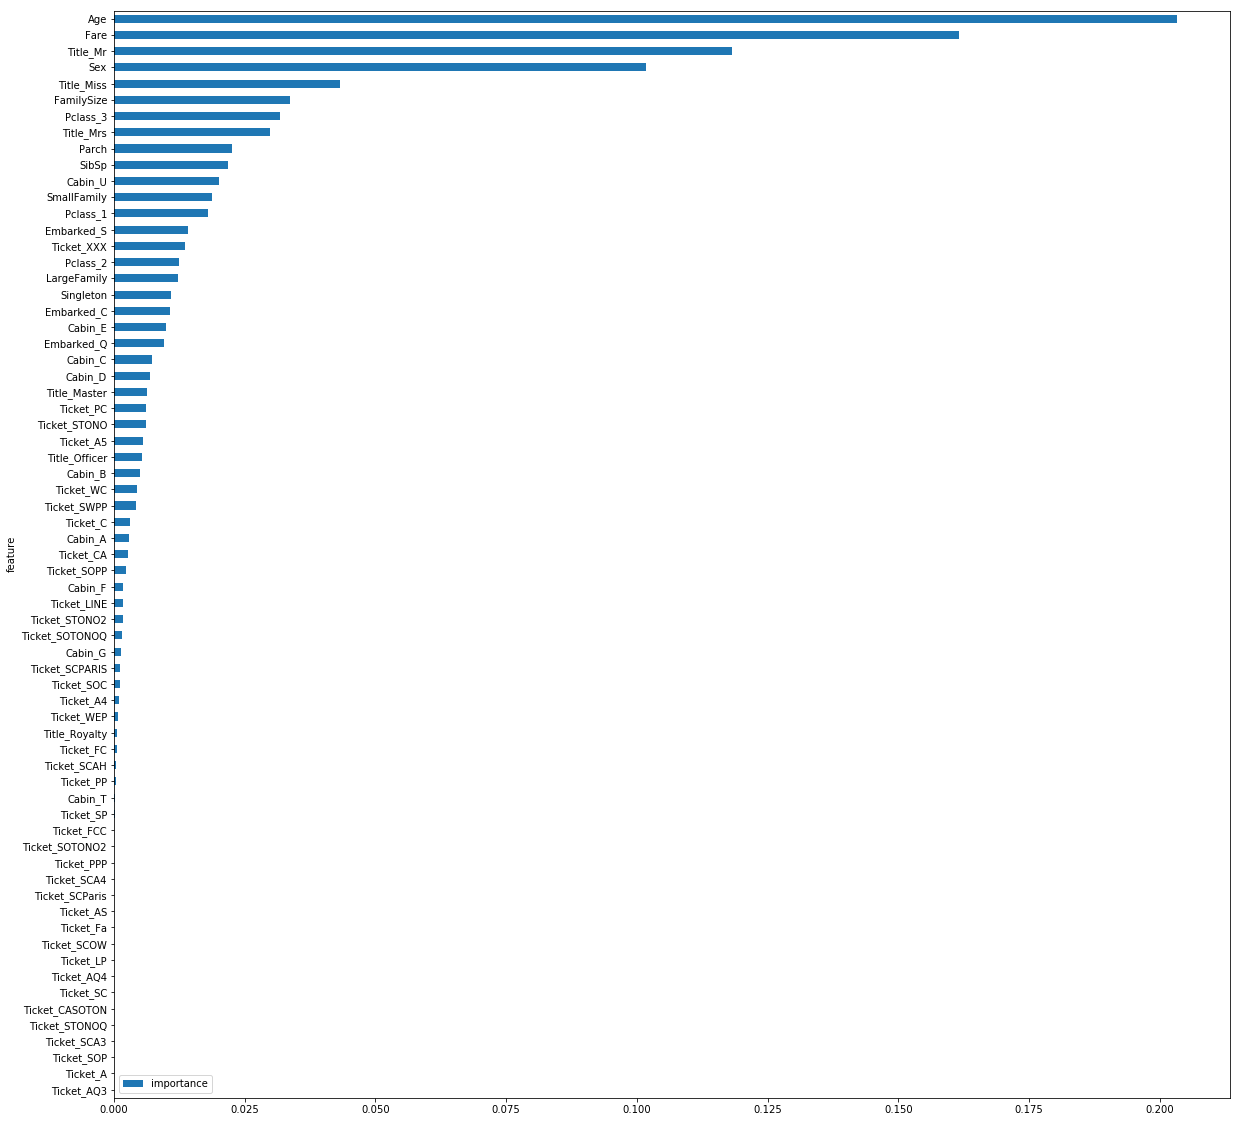

In [347]:
features.plot(kind='barh', figsize=(20, 20))

In [348]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(x_train)
train_reduced.shape

(712, 13)

in order to optimize the algorithm, the parameters for the algorithm were fine tuned

In [359]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(**parameters)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [358]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

compute_score(model, x_train, y_train, scoring='accuracy')

0.83156464951490427

In [239]:
test['Survived'] = model.predict(df_test).astype(int)
test[['PassengerId', 'Survived']].to_csv('results.csv', index=False)